In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [3]:
arc_data = Table.read('panoptes_project/arc_table_ml.fits')
samples = Table.read('../fits/sparcfire/sparcfire_samples.fits')
mass_data = Table.read('../fits/Simard+Mendel/mendel_masses.fits')
sfr_data = Table.read('../fits/SF_fits/sfrs.fits')

#### First task: define the sample:

In [21]:
sample_columns = ('in_ml_dr7','in_spiral','axial_ok')

in_sample = np.all([samples[c] for c in sample_columns],axis=0)
has_id = gz2_data['dr8objid'] > 0
in_sample = np.all([in_sample,has_id],axis=0)

print('{} spirals in the M*-limited sample!'.format(in_sample.sum()))
sample_ids = gz2_data['dr8objid'][in_sample]

6597 spirals in the M*-limited sample!


In [23]:
arc_ok = arc_data['p_good_predicted'] == 1
print('{}/{} arcs OK!'.format(arc_ok.sum(),len(arc_ok)))

sample_ok = np.any([arc_data['gxyName'] == id_ 
                    for id_ in sample_ids],axis=0)

print('+ {} are in the ML sample!'.format((arc_ok*sample_ok).sum()))

good_arcs = arc_data[(arc_ok*sample_ok).astype(bool)]

4246/33809 arcs OK!
+ 4246 are in the ML sample!


In [24]:
from combining_catalogues import match_ids, make_matched_catalogue

matched_ids = match_ids(good_arcs,gz2_data,'gxyName','dr8objid')

gz2_arcs = make_matched_catalogue(good_arcs,gz2_data,matched_ids)
sfr_arcs = make_matched_catalogue(good_arcs,sfr_data,matched_ids)
mass_arcs = make_matched_catalogue(good_arcs,mass_data,matched_ids)

4246 galaxies in the reference catalogue
248883 galaxies in the match catalogue
---> 4246 matches in total


In [32]:
# First task: plot up the arm characteristics:
def get_gz2_stats(gz2_data):
    m_colnames = ['t11_arms_number_a31_1_debiased_rh',
                  't11_arms_number_a32_2_debiased_rh',
                  't11_arms_number_a33_3_debiased_rh',
                  't11_arms_number_a34_4_debiased_rh',
                  't11_arms_number_a36_more_than_4_debiased_rh']#,
                  #'t11_arms_number_a37_cant_tell_debiased_rh']
    
    w_colnames = ['t10_arms_winding_a28_tight_debiased_rh',
                  't10_arms_winding_a29_medium_debiased_rh',
                  't10_arms_winding_a30_loose_debiased_rh']
    
    m_array = np.array([gz2_data[column] for column in m_colnames]).T
    w_array = np.array([gz2_data[column] for column in w_colnames]).T
    m = np.argmax(m_array,axis=1) + 1
    w = np.argmax(w_array,axis=1) + 1
    m_max = np.max(m_array,axis=1)
    w_max = np.max(w_array,axis=1)#
    #_ = plt.hist(m,bins=100)
    def measure_wtd_avg(array):
        N_rows, N_columns = np.shape(array)
        wtd_avg = np.zeros(N_rows)
        for c in range(N_columns):
            wtd_avg += array[:,c]*(c+1)
        wtd_avg_sum  = np.sum(array,axis=1)
        return wtd_avg/wtd_avg_sum
    m_wtd_avg = measure_wtd_avg(m_array)
    w_wtd_avg = measure_wtd_avg(w_array)
    p_bar = gz2_data['t03_bar_a06_bar_debiased_rh']
    return m, w, m_max, w_max ,m_wtd_avg, w_wtd_avg, p_bar


def measure_N_detected(ids,arc_data):
    N_detected = []
    pitch_angles = []
    for id_ in ids:
        arcs_id = arc_data[arc_data['gxyName'] == id_]
        N_detected_id = arcs_id['p_good_predicted'].sum()
        N_detected.append(N_detected_id)
        good_arcs = arcs_id['p_good_predicted'] == 1
        length_weights = arcs_id['arc_length'][good_arcs]
        Ps = arcs_id['pitch_angle_absolute'][good_arcs]
        if N_detected_id != 0:
            pitch_angle = np.average(Ps,weights=length_weights)
        else:
            pitch_angle = -999
        pitch_angles.append(pitch_angle)
    return N_detected, pitch_angles

m, w, m_max, w_max, m_wtd_avg, w_wtd_avg, p_bar = \
get_gz2_stats(gz2_arcs)

arc_level_data = Table()
arc_level_data['id'] = good_arcs['gxyName']

arc_level_data['total_mass'] = mass_arcs['bulge+disc']
arc_level_data['bulge_mass'] = mass_arcs['bulge']
arc_level_data['disc_mass'] = mass_arcs['disc']
arc_level_data['btr'] = 10**(mass_arcs['bulge']-mass_arcs['bulge+disc'])
arc_level_data['btr'][np.isfinite(arc_level_data['btr']) ==  False] = -999

arc_level_data['m'] = m
arc_level_data['w'] = w
arc_level_data['w_wtd_avg'] = w_wtd_avg
arc_level_data['m_wtd_avg'] = m_wtd_avg
arc_level_data['m_max'] = m_max
arc_level_data['w_max'] = w_max
arc_level_data['p_bar'] = p_bar

arc_level_data['sfr_mpa'] = sfr_arcs['sfr_mpa']
arc_level_data['sfr_fuv'] = sfr_arcs['sfr_fuv']
arc_level_data['sfr_22'] = sfr_arcs['sfr_22']
arc_level_data['sfr_total'] = sfr_arcs['sfr_mpa']
arc_level_data['w4_ok'] = sfr_arcs['w4'] >= 2
arc_level_data['F_ok'] = sfr_arcs['F'] >= 2
arc_level_data['mir_fraction'] = sfr_arcs['mir_fraction']

arc_level_data.write('arc_level_data.fits',overwrite=True)

 **What we see here is that the new method is not particularly desirable for selecting the correct _number_ of arcs**
 
- We should, however, check how well it does at reproducing the pitch angles and other features?

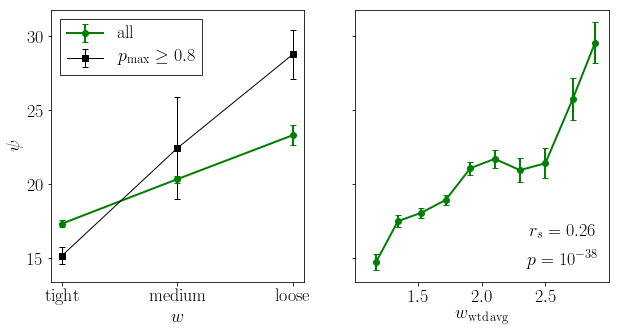

In [46]:
from xy_plots import x_vs_y

wlabels = ('tight','medium','loose')
fig, axarr = plt.subplots(1,2,figsize=(10,5),sharey=True)

########################
ax = axarr[0]

xy = x_vs_y(arc_level_data['w'],
            good_arcs['pitch_angle_absolute'])
xy.discrete_vs_continuous_binned(ax,marker='o',color='g',lw=2,capsize=3,
                                 label='all')

best_w = arc_level_data['w_max'] >= 0.8

xy = x_vs_y(arc_level_data['w'][best_w],
            good_arcs['pitch_angle_absolute'][best_w])
xy.discrete_vs_continuous_binned(ax,marker='s',color='k',lw=1,capsize=3,
                                 label='$p_\mathrm{max} \geq 0.8$')

_ = ax.set_xlabel('$w$')
_ = ax.set_ylabel('$\psi$')
_ = ax.set_xticks([1,2,3])
_ = ax.set_xticklabels(wlabels)
_ = ax.legend(fancybox=False,edgecolor='k')
########################
ax = axarr[1]

xy = x_vs_y(arc_level_data['w_wtd_avg'],
            good_arcs['pitch_angle_absolute'])
xy.continuous_vs_continuous_binned(ax,marker='o',color='g',lw=2,capsize=3)
xy.show_spearmanr(ax,location='lower right')

_ = ax.set_xlabel('$w_\mathrm{wtd \, avg}$')
_ = ax.set_xlim(1,3)

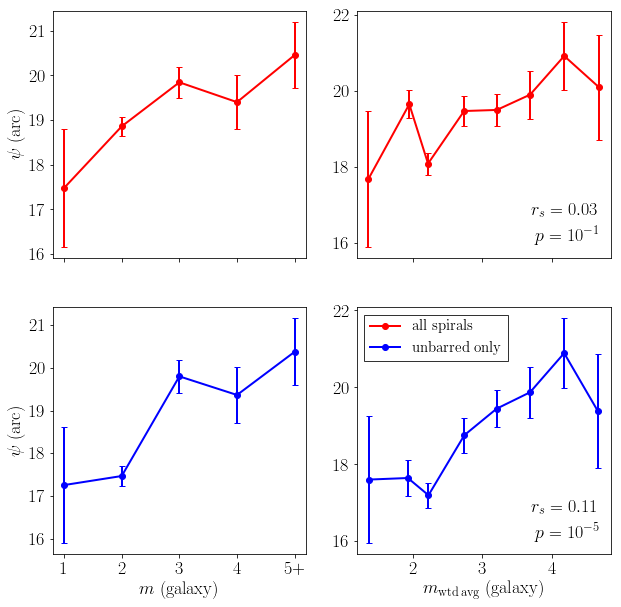

In [48]:
unbarred = arc_level_data['p_bar'] < 0.5

mlabels = ('1','2','3','4','5+')
fig, axarr = plt.subplots(2,2,figsize=(10,10),
                          sharex='col')

axarr = axarr.ravel()

#ok_m = arc_level_data['m'] != 6

################
ax = axarr[0]
xy = x_vs_y(arc_level_data['m'],
            good_arcs['pitch_angle_absolute'])
xy.discrete_vs_continuous_binned(ax,marker='o',color='r',lw=2,capsize=3,
                                 label='all')

################
ax = axarr[1]
xy = x_vs_y(arc_level_data['m_wtd_avg'],
            good_arcs['pitch_angle_absolute'])
xy.continuous_vs_continuous_binned(ax,bins=8,
                                   marker='o',color='r',lw=2,capsize=3)
xy.show_spearmanr(ax,location='lower right')

################
ax = axarr[2]
xy = x_vs_y(arc_level_data['m'][unbarred],
            good_arcs['pitch_angle_absolute'][unbarred])
xy.discrete_vs_continuous_binned(ax,marker='o',color='b',lw=2,capsize=3,label='all')

################
ax = axarr[3]
xy = x_vs_y(arc_level_data['m_wtd_avg'][unbarred],
            good_arcs['pitch_angle_absolute'][unbarred])
xy.continuous_vs_continuous_binned(ax,bins=8,label=None,
                                   marker='o',color='b',lw=2,capsize=3)
xy.show_spearmanr(ax,location='lower right')

axarr[0].set_ylabel('$\psi$ (arc)')
axarr[1].set_xticks([1,2,3,4,5])
axarr[2].set_ylabel('$\psi$ (arc)')
axarr[2].set_xlabel('$m$ (galaxy)')
axarr[2].set_xticks([1,2,3,4,5])
axarr[2].set_xticklabels(mlabels)

axarr[3].set_xlabel('$m_\mathrm{wtd \, avg}$ (galaxy)')
axarr[3].plot([],[],'ro-',lw=2,label='all spirals')
axarr[3].plot([],[],'bo-',lw=2,label='unbarred only')
axarr[3].legend(fancybox=False,edgecolor='k',loc='upper left',fontsize=15)

Here we see the result that we have seen before: there is a correlation between pitch angle and arm number: galaxies with _more spiral arms_ show _looser spiral structures_. The next stage will be to look at how arm numbers and pitch angles vary w.r.t bulge mass, disc mass and total mass.

#### Bar presence vs. pitch angle

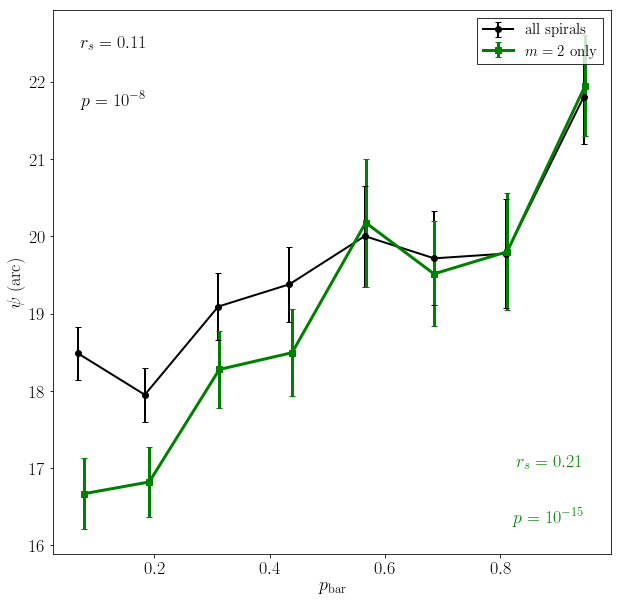

In [50]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

m_2 = arc_level_data['m'] == 2
arc_level_data['P'] = good_arcs['pitch_angle_absolute']

xy = x_vs_y(arc_level_data['p_bar'],
            arc_level_data['P'])
xy.continuous_vs_continuous_binned(ax,marker='o',color='k',lw=2,capsize=3,
                                   label='all spirals',bins=8)
xy.show_spearmanr(ax,location='upper left')

xy = x_vs_y(arc_level_data['p_bar'][m_2],
            arc_level_data['P'][m_2])
xy.continuous_vs_continuous_binned(ax,marker='s',color='g',lw=3,capsize=3,
                                   label='$m=2$ only',bins=8)
xy.show_spearmanr(ax,color='g',location='lower right')

_ = ax.legend(loc='upper right',fancybox=False,edgecolor='k',fontsize=15)
_ = ax.set_xlabel('$p_\mathrm{bar}$')
_ = ax.set_ylabel('$\psi$ (arc)')

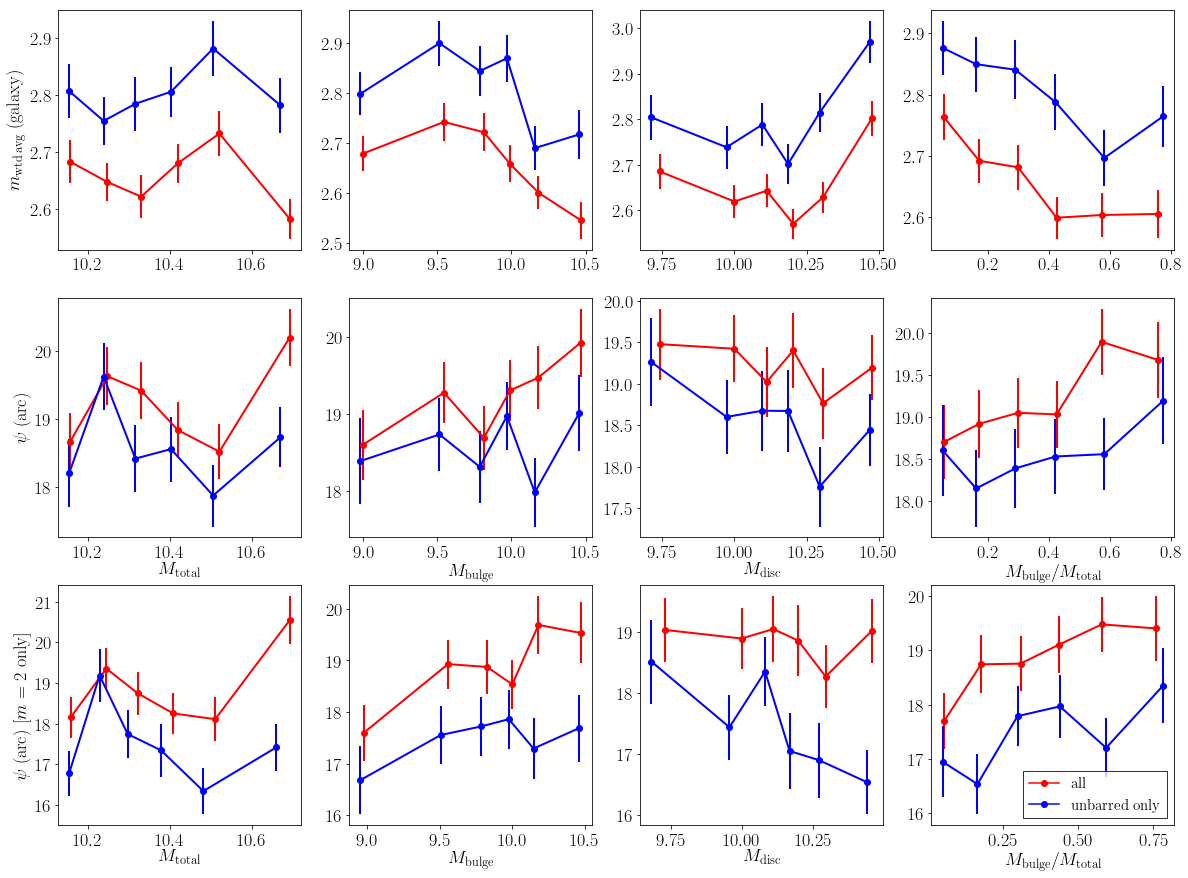

In [51]:
def xy_mass_row(axarr,table,y_column='m_wtd_avg',x_label=True,**kwargs):
    x_columns = ('total_mass','bulge_mass','disc_mass','btr')
    x_labels = ('$M_\mathrm{total}$','$M_\mathrm{bulge}$',
                '$M_\mathrm{disc}$','$M_\mathrm{bulge}/M_\mathrm{total}$')
    for xlabel, x_column, ax in zip(x_labels,x_columns,axarr):
        xy = x_vs_y(table[x_column],table[y_column])
        xy.continuous_vs_continuous_binned(ax,bins=6,equal_N=True,**kwargs)
        if x_label is True:
            ax.set_xlabel(xlabel)
    return None

unbarred_m_2 = (unbarred*m_2).astype(bool)

fig, axarr = plt.subplots(3,4,figsize=(20,15))

xy_mass_row(axarr[0],arc_level_data,'m_wtd_avg',False,
            color='r',lw=2,marker='o')
xy_mass_row(axarr[0],arc_level_data[unbarred],'m_wtd_avg',False,
            color='b',lw=2,marker='o')

xy_mass_row(axarr[1],arc_level_data,'P',False,
            color='r',lw=2,marker='o')
xy_mass_row(axarr[1],arc_level_data[unbarred],'P',True,
            color='b',lw=2,marker='o')

xy_mass_row(axarr[2],arc_level_data[m_2],'P',False,
            color='r',lw=2,marker='o',label=None)
xy_mass_row(axarr[2],arc_level_data[unbarred_m_2],'P',True,
            color='b',lw=2,marker='o',label=None)

_ = axarr[0,0].set_ylabel('$m_\mathrm{wtd \, avg}$ (galaxy)')
_ = axarr[1,0].set_ylabel('$\psi$ (arc)')
_ = axarr[2,0].set_ylabel('$\psi$ (arc) [$m=2$ only]')
_ = axarr[-1,-1].plot([],[],'ro-',label='all')
_ = axarr[-1,-1].plot([],[],'bo-',label='unbarred only')
_ = axarr[-1,-1].legend(fancybox=False,edgecolor='k',fontsize=15)

**Finally, compare the SFRs?**

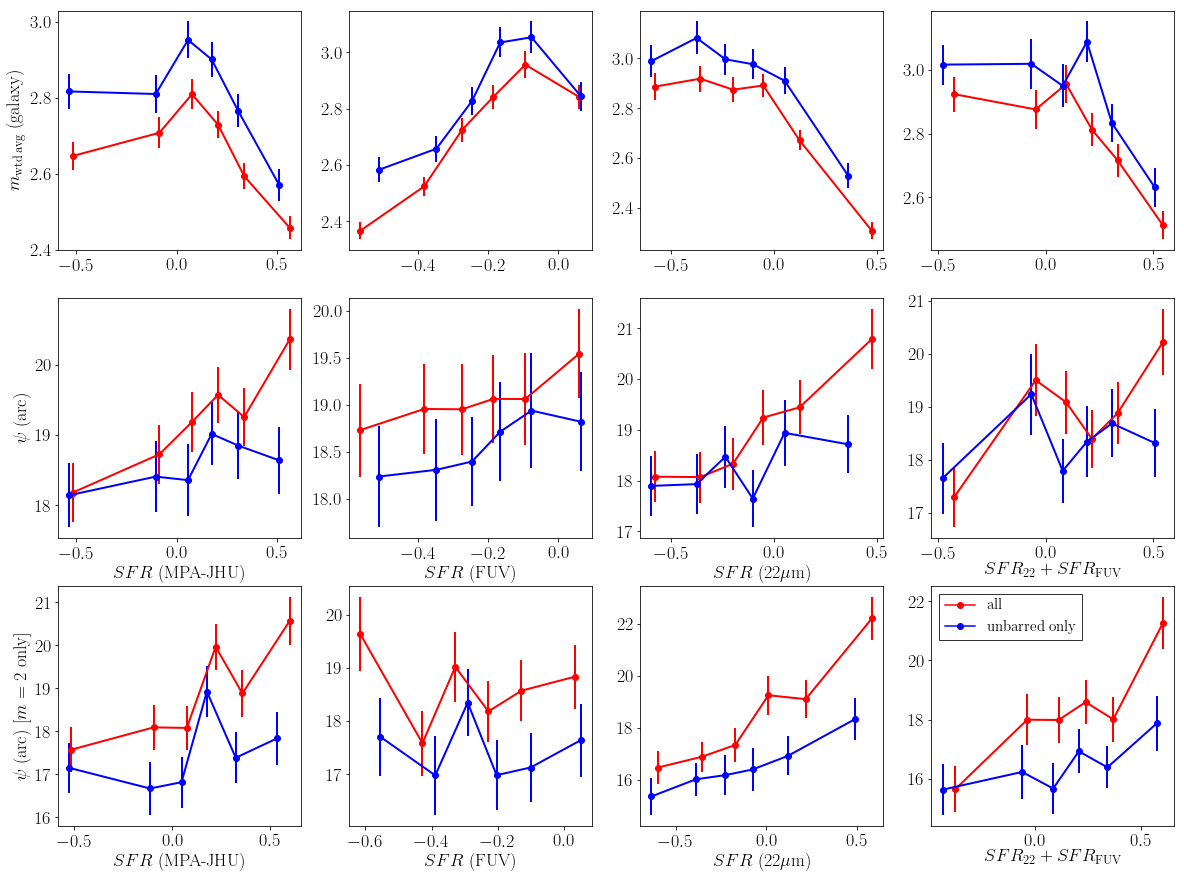

In [52]:
def xy_sfr_row(axarr,table,y_column='m_wtd_avg',x_label=True,**kwargs):
    x_columns = ('sfr_mpa','sfr_fuv','sfr_22','sfr_total')
    x_labels = ('$SFR$ (MPA-JHU)','$SFR$ (FUV)',
                '$SFR$ (22$\mu$m)','$SFR_{22} + SFR_\mathrm{FUV}$')
    masks = (table['sfr_mpa'] >= -10, table['F_ok'], table['w4_ok'],
             (table['F_ok']*table['w4_ok']).astype(bool))
    for xlabel, x_column, mask, ax in zip(x_labels,x_columns,masks,axarr):
        xy = x_vs_y(table[x_column][mask],table[y_column][mask])
        xy.continuous_vs_continuous_binned(ax,bins=6,equal_N=True,**kwargs)
        if x_label is True:
            ax.set_xlabel(xlabel)
    return None

fig, axarr = plt.subplots(3,4,figsize=(20,15))

xy_sfr_row(axarr[0],arc_level_data,'m_wtd_avg',False,
            color='r',lw=2,marker='o')
xy_sfr_row(axarr[0],arc_level_data[unbarred],'m_wtd_avg',False,
            color='b',lw=2,marker='o')

xy_sfr_row(axarr[1],arc_level_data,'P',False,
            color='r',lw=2,marker='o')
xy_sfr_row(axarr[1],arc_level_data[unbarred],'P',True,
            color='b',lw=2,marker='o')

xy_sfr_row(axarr[2],arc_level_data[m_2],'P',False,
            color='r',lw=2,marker='o',label=None)
xy_sfr_row(axarr[2],arc_level_data[unbarred_m_2],'P',True,
            color='b',lw=2,marker='o',label=None)

_ = axarr[0,0].set_ylabel('$m_\mathrm{wtd \, avg}$ (galaxy)')
_ = axarr[1,0].set_ylabel('$\psi$ (arc)')
_ = axarr[2,0].set_ylabel('$\psi$ (arc) [$m=2$ only]')
_ = axarr[-1,-1].plot([],[],'ro-',label='all')
_ = axarr[-1,-1].plot([],[],'bo-',label='unbarred only')
_ = axarr[-1,-1].legend(fancybox=False,edgecolor='k',fontsize=15)